In [22]:
import re
import requests
import smtplib
from email.message import EmailMessage
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import os
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from jinja2 import Environment, FileSystemLoader
from jinja2 import Template
import plotly.express as px
import json

# from fpdf import FPDF
# import yake
# import docx
# from docx.shared import Inches
# from docx.enum.text import WD_ALIGN_PARAGRAPH


In [3]:
# Define time function
def get_timestamp():
    t = time.localtime()
    return time.strftime('%m-%d-%Y %H:%M', t)

# Send a request to the URL
def get_articles(search_terms):
    #print("Last updated:",get_timestamp())
    
    url = 'https://pubmed.ncbi.nlm.nih.gov/?term=' + search_terms +'&sort=date'
    response = requests.get(url)
    response.raise_for_status()

    # Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    href_tags = soup.find_all(href=True)

    # mydivs = soup.find_all("div", {"class": "stylelistrow"})
    mydivs = soup.find_all("span", {"class": "value"})

    import re

    text = str(mydivs[0])
    pattern = r'<span class="value">([\d,]+)</span>'

    match = re.search(pattern, text)

    if match:
        extracted_number = match.group(1)
        # Remove commas from the extracted number
        extracted_number = extracted_number.replace(',', '')
        extracted_number = int(extracted_number)
        #print("Search terms:",search_terms, "Articles found:",extracted_number)

    return search_terms,extracted_number

In [18]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

In [38]:
search_terms = ["dementia","dementia+alzheimers","alzheimers","alzheimers+disease","dementia+MRI","alzheimers+MRI",
                ]

data = []
data_dict = {}
add_element(data_dict,'Timestamp',get_timestamp())
for k in search_terms:
    search_terms,extracted_number =  get_articles(k)
    add_element(data_dict,search_terms,extracted_number)
    data.append([search_terms,extracted_number])


In [39]:
data_dict

{'Timestamp': ['01-18-2024 11:40'],
 'dementia': [276950],
 'dementia+alzheimers': [212392],
 'alzheimers': [225072],
 'alzheimers+disease': [211136],
 'dementia+MRI': [24892],
 'alzheimers+MRI': [18612]}

In [41]:
def update_pubmed_json(data_dict):
    with open("E:/Kaggle/pradhanhitesh/data/pubmed.json") as doc:
        docObj = json.load(doc)
        docObj.append(
            data_dict
        )
    with open("E:/Kaggle/pradhanhitesh/data/pubmed.json", 'w') as json_file:
        json.dump(docObj, json_file, 
                  indent=4,  
                  separators=(',',': '))
    return

In [42]:
update_pubmed_json(data_dict=data_dict)

In [5]:
data_df = pd.DataFrame(data,columns=['Keywords','Count'])

In [6]:
data_df.sort_values(by='Count',ascending=False)

,Keywords,Count
0,dementia,276950
2,alzheimers,225072
1,dementia+alzheimers,212392
3,alzheimers+disease,211136
4,dementia+MRI,24892
5,alzheimers+MRI,18612
6,dementia+alzheimers+MRI,17771


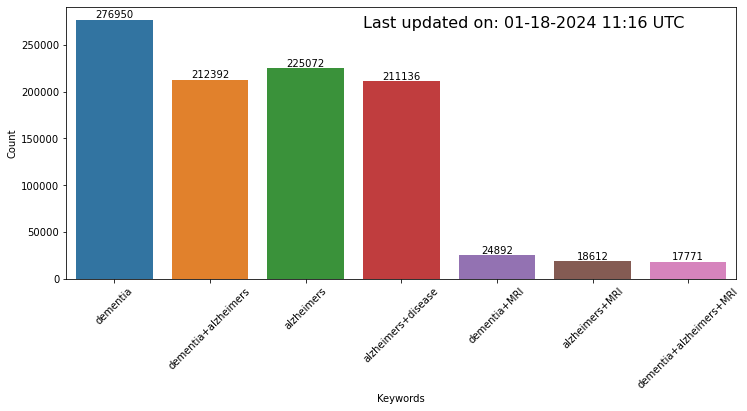

In [8]:
plt.figure(figsize=(12,5))
plt.xticks(range(len(data_df)), list(data_df['Keywords']), rotation=45)
ax = sns.barplot(data=data_df,x='Keywords',y='Count')
ax.bar_label(ax.containers[0])
txt = "Last updated on: " + str(get_timestamp()) + " UTC"
plt.text(2.6, 269000, txt, fontsize = 16)
plt.show()

In [43]:
import re
import requests
import smtplib
from email.message import EmailMessage
from bs4 import BeautifulSoup
import datetime
import os
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from jinja2 import Environment, FileSystemLoader
import json

def get_timestamp():
    t = time.localtime()
    return time.strftime('%Y-%m-%d %H:%M:%S', t)

def get_metadata(search_terms):

    # Set the PubMed URL    
    url = 'https://pubmed.ncbi.nlm.nih.gov/?term=' + search_terms +'&sort=date'
    response = requests.get(url)
    response.raise_for_status()

    # Parse the content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    href_tags = soup.find_all(href=True)
    mydivs = soup.find_all("span", {"class": "value"})

    # Extract the number of articles for the keyword_search
    text = str(mydivs[0])
    pattern = r'<span class="value">([\d,]+)</span>'
    match = re.search(pattern, text)

    if match:
        extracted_number = match.group(1)
        # Remove commas from the extracted number
        extracted_number = int(extracted_number.replace(',', ''))

    return search_terms,extracted_number

def add_element(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

def arrange_metadata(search_terms):

    data = []
    data_dict = {}
    add_element(data_dict,'Timestamp',get_timestamp())
    for k in search_terms:
        search_terms,extracted_number =  get_metadata(k)
        add_element(data_dict,search_terms,extracted_number)
        data.append([search_terms,extracted_number])
    
    data_df = pd.DataFrame(data,columns=['Keywords','Count'])
    data_df = data_df.sort_values(by='Count',ascending=False)

    return data_df,data_dict

def update_pubmed_json(data_dict):
    with open("data/pubmed.json") as doc:
        docObj = json.load(doc)
        docObj.append(
            data_dict
        )
    with open("data/pubmed.json", 'w') as json_file:
        json.dump(docObj, json_file, 
                  indent=4,  
                  separators=(',',': '))
    return

def generate_plot(data_df,time):
    # Set defaults for plot
    plt.figure(figsize=(12,5))
    plt.xticks(range(len(data_df)), list(data_df['Keywords']), rotation=45)

    # Create barplots
    ax = sns.barplot(data=data_df,x='Keywords',y='Count')
    ax.bar_label(ax.containers[0])
    txt = "Last updated on: " + str(time) + " UTC"
    plt.text(2.6, 269000, txt, fontsize = 16)
 
    # Save the figure
    plt.savefig('figure.png',bbox_inches='tight')
    plt.close()

    return

def generate_html_for_plot():
    all_files = os.listdir("./")
    png_files = [file for file in all_files if file.endswith('.png')]

    template_vars = {
        'plot' : f'<img src="{png_files[0]}" width="650" height="400">'
        }
    
    return template_vars

In [44]:
search_terms = ["dementia","dementia+alzheimers","alzheimers","alzheimers+disease","dementia+MRI","alzheimers+MRI",
                "dementia+alzheimers+MRI"]

data_df,data_dict = arrange_metadata(search_terms)

In [45]:
data_dict

{'Timestamp': ['2024-01-18 11:51:59'],
 'dementia': [276950],
 'dementia+alzheimers': [212392],
 'alzheimers': [225072],
 'alzheimers+disease': [211136],
 'dementia+MRI': [24892],
 'alzheimers+MRI': [18612],
 'dementia+alzheimers+MRI': [17771]}

In [46]:
data_df

,Keywords,Count
0,dementia,276950
2,alzheimers,225072
1,dementia+alzheimers,212392
3,alzheimers+disease,211136
4,dementia+MRI,24892
5,alzheimers+MRI,18612
6,dementia+alzheimers+MRI,17771
